In [13]:
import pandas as pd
import seaborn as sns
# from google.colab import files
import io

In [ ]:
# uploaded = files.upload()

Saving export-AddressCount.csv to export-AddressCount (1).csv
Saving export-DailyActiveEthAddress.csv to export-DailyActiveEthAddress.csv
Saving export-MarketCap.csv to export-MarketCap.csv
Saving export-TxGrowth.csv to export-TxGrowth.csv


In [3]:
# df_main_ar = [pd.read_csv(io.BytesIO(uploaded[d])) for d in uploaded]

import pandas as pd
import glob
path = r'./data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame[100:]
# [df_ad, df_day, df_mc, df_txg, tmp] = frame
# df_day

,Date(UTC),UnixTimeStamp,Supply,MarketCap,Price,Value,Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count
0,7/30/2015,1.438214e+09,7.204931e+07,0.0,0.00,NaN,NaN,NaN,NaN
1,7/31/2015,1.438301e+09,7.208550e+07,0.0,0.00,NaN,NaN,NaN,NaN
2,8/1/2015,1.438387e+09,7.211320e+07,0.0,0.00,NaN,NaN,NaN,NaN
3,8/2/2015,1.438474e+09,7.214143e+07,0.0,0.00,NaN,NaN,NaN,NaN
4,8/3/2015,1.438560e+09,7.216940e+07,0.0,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12520,6/3/2022,1.654214e+09,NaN,NaN,NaN,1.081028e+06,NaN,NaN,NaN
12521,6/4/2022,1.654301e+09,NaN,NaN,NaN,1.080737e+06,NaN,NaN,NaN
12522,6/5/2022,1.654387e+09,NaN,NaN,NaN,1.067954e+06,NaN,NaN,NaN
12523,6/6/2022,1.654474e+09,NaN,NaN,NaN,1.039131e+06,NaN,NaN,NaN


In [33]:
df_day['Date(UTC)'] = df_day['Date(UTC)'].apply(pd.to_datetime)

,Date(UTC),Unique Address Total Count,Unique Address Receive Count,Unique Address Sent Count,pc_change
0,2015-07-30,8894,1,8893,NaN
1,2015-07-31,0,0,0,-1.000000
2,2015-08-01,0,0,0,NaN
3,2015-08-02,0,0,0,NaN
4,2015-08-03,0,0,0,NaN
...,...,...,...,...,...
2500,2022-06-03,415205,304938,242313,0.010831
2501,2022-06-04,401055,295800,224918,-0.034080
2502,2022-06-05,392139,291812,220882,-0.022231
2503,2022-06-06,428837,318763,239729,0.093584


In [54]:
df_day['year'] = [d.year for d in df_day['Date(UTC)']]
df_day['month'] = [d.month for d in df_day['Date(UTC)']]
df_day['day'] = [d.day for d in df_day['Date(UTC)']]
df_day_s = df_day[df_day['day'] == 1]
# df_day_s = df_day_s.assign(pc_change = lambda dataframe : dataframe['Unique Address Total Count'].pct_change())
df_day_s = df_day_s[2:]
# df_day_s = df_day_s.assign(norm_by_first = lambda dataframe : dataframe['Unique Address Total Count'] / df_day_s['Unique Address Total Count'][0])
df_day_s_n = df_day_s['Unique Address Total Count'].diff().cumsum() / df_day_s['Unique Address Total Count'].iloc[0]
df_day_s_n

# df_day.dtypes

63             NaN
94        0.446404
124       0.196744
155       0.594980
186       1.849389
           ...    
2378    350.912483
2406    359.025102
2437    343.729986
2467    314.381954
2498    300.521031
Name: Unique Address Total Count, Length: 81, dtype: float64

In [55]:
df_mc['Date(UTC)'] = df_mc['Date(UTC)'].apply(pd.to_datetime)
df_mc['year'] = [d.year for d in df_mc['Date(UTC)']]
df_mc['month'] = [d.month for d in df_mc['Date(UTC)']]
df_mc['day'] = [d.day for d in df_mc['Date(UTC)']]
df_mc_s = df_mc[df_mc['day'] == 1]
df_mc_s = df_mc_s[2:]
df_mc_s_n = df_mc_s['MarketCap'].diff().cumsum() / df_mc_s['MarketCap'].iloc[0]
df_mc_s_n
# # df_day_s
# tmp
# df_day.dtypes

63              NaN
94         0.561279
124        0.307842
155        0.413497
186        2.334031
           ...     
2378    6647.222108
2406    7114.014628
2437    8288.221704
2467    6800.523192
2498    4387.731381
Name: MarketCap, Length: 81, dtype: float64

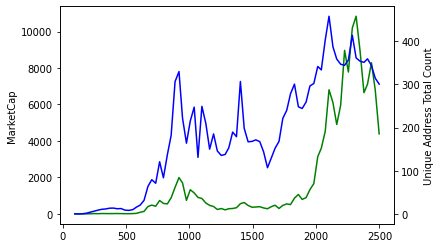

In [64]:
import matplotlib.pyplot as plt
sns.lineplot(data = df_mc_s_n, color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_day_s_n, color="b", ax=ax2)

In [67]:
df_merged_day_mc_s_n = pd.concat([df_mc_s_n, df_day_s_n], axis = 1)

In [69]:
df_merged_day_mc_s_n['MarketCap'].corr(df_merged_day_mc_s_n['Unique Address Total Count'])

0.7502683877968985

In [75]:
df_day_s['squared_users'] = [d*(d-1)/2 for d in df_day_s['Unique Address Total Count']] 
# .diff().cumsum() / df_day_s['Unique Address Total Count'].iloc[0]

In [77]:
df_day_s_n_squ = df_day_s['squared_users'].diff().cumsum() / df_day_s['squared_users'].iloc[0]

In [78]:
df_day_s_n_squ 

63                NaN
94           1.092524
124          0.432355
155          1.544604
186          7.122598
            ...      
2378    123925.231756
2406    129704.825461
2437    118918.207560
2467     99532.088702
2498     90975.448494
Name: squared_users, Length: 81, dtype: float64

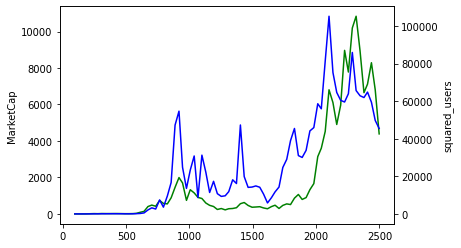

In [80]:
sns.lineplot(data = df_mc_s_n, color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_day_s_n_squ/2, color="b", ax=ax2)

In [83]:
df_day_s_n_squ.corr(df_mc_s_n)

0.8375885631812113

In [2]:
df_day_s_n_squ

NameError: ignored